In [183]:
import numpy as np
from matplotlib import pyplot as plt
import DataUtils as data

plt.style.use("dark_background")

In [ ]:
# TODO: Use EM to re-estimate the A matrix

In [166]:
class KalmanFilter():
    """
    Initialization:
    1. Initialize state of the filter
    2. Initialize belief of the state

    Predict:
    1. Use process model to predict state at the next time step
    2. Adjust belief to account for hte uncertainty in prediction

    Update:
    1. Get a measurement & associated belief about its accuracy
    2. Compute residual between estimated state & measurement
    3. Compute scaling factor absed on whether the measurement or prediction
    is more accurate
    4. Set state between prediction & measurement based on scaling factor
    5. Update belief in the state based on how certain we are in the measurement
    """
    def __init__(self, prior, A, C, Q):
        '''

        '''


        self.prior = prior

        self.A = A
        self.C = C
        self.Q = Q # system cov

        self.mean = prior
        self.cov = np.eye(6)

        self.Kalman_gain = None
        self.mean_predict = None
        self.cov_predict = None

    def predict(self, R):
        self.mean_predict = self.A @ self.mean
        self.cov_predict = self.A @ self.cov @ self.A.T + R

        self.Kalman_gain = self.cov_predict @ self.C.T @ np.linalg.inv( self.C @ self.cov_predict @ self.C.T + self.Q )

    def update(self, measurement):
        shape = self.Kalman_gain.shape[0]
        # self.mean_predict = self.C @ measurement
        temp_change = self.Kalman_gain @ (measurement.reshape(shape,1) - (self.C @ self.mean_predict))
        temp_change[3:] = np.zeros((3, 1))

        # print(temp_change)

        self.mean = self.mean_predict + temp_change
        self.cov = (np.eye(shape,dtype=float) - self.Kalman_gain @ self.C) @ self.cov_predict

        # print(self.mean,  "\n-----------------------")

    def curr_state(self):
        return self.mean, self.cov

    def get_predictions(self, measurements):
        shape = self.cov.shape[0]

        states = np.zeros(shape=(shape, measurements.shape[1]),dtype=float)
        states[:,0] = self.prior.reshape(-1)
        for i in range(1,measurements.shape[1]):
            self.predict()
            self.update( measurements[:,i] )
            states[:,i] = self.currState()[0].reshape(-1)

        return states

In [148]:
# Load Data
data_interface = data.DataInterface(
    "/home/jay/Documents/urban16/sensor_data/gps.csv",
    "/home/jay/Documents/urban16/sensor_data/xsens_imu.csv",
    "/home/jay/Documents/urban16/sensor_data/encoder.csv"
)

In [176]:
class SensorReader:
    def __init__(self, radiusOfEarth, encoder_resolution, encoder_diameterL, encoder_diameterR):
        self.data_interface = data.DataInterface(
           "/home/jay/Documents/urban16/sensor_data/gps.csv",
            "/home/jay/Documents/urban16/sensor_data/xsens_imu.csv",
            "/home/jay/Documents/urban16/sensor_data/encoder.csv"
        )
        # data -> (lon,lat,alt,left,right,yaw,pitch,roll)
        self.R = radiusOfEarth
        self.res = encoder_resolution
        self.angle_to_rad = np.pi/180
        self.enc_radL = encoder_diameterL / 2
        self.enc_radR = encoder_diameterR / 2

        self.init_data = self.parse(self.data_interface.read())
        self.meas = self.init_data.copy()
        self.meas[0:5] = 0 #re-init

    def parse(self, data):
        gps = data['gps_data']
        imu = data['imu_data']
        enc = data['encoders_data']
        lat, lon, alt = gps[1:4]
        pitch, roll, yaw = imu[5:8]
        left, right = enc[1:3]

        lat = lat * np.pi/180 * R
        lon = lon * np.pi/180 * R
        left = left * 2 * np.pi/self.res * self.enc_radL
        right = right * 2 * np.pi/self.res * self.enc_radR

        pitch = pitch * np.pi / 180
        yaw = yaw * np.pi / 180
        roll = roll * np.pi / 180
        return np.array([[lon,lat,alt,left,right,yaw,pitch,roll]]).T

    def read(self):
        self.meas = self.parse(self.data_interface.read())
        self.meas[0:5] -= self.init_data[0:5]
        return self.meas

In [177]:
data_interface.reset()

In [184]:
R = 6_371_000 #earth's radius in meters
encDiamL = 0.623022
encDiamR = 0.622356
res = 4096
wheelbase = 1.5285

sensors = SensorReader(R, res, encDiamL, encDiamR)

init0 = sensors.read()

In [185]:
A = np.zeros((6,6))
A[0:3, 0:3] = np.eye(3) * 2
A[0:3, 3:6] = np.eye(3) * -1
A[3:6, 0:3] = np.eye(3)

prior = np.array([[0, 0, 0, 0, 0, 0]])

C = np.eye(6)

Q = np.eye(6)

kal = KalmanFilter(prior.T, A, C, Q)

In [188]:
previous_reading = np.array([[0,0,0]]).T
d = np.array([[0,0,0]]).T
for i in range(5000):
    reading = sensors.read()
    R = np.eye(6)
    # print(reading)
    # temp = reading[4:].reshape((3,3))
    # R[0:3, 0:3] = temp
    #R[3:6, 3:6] = temp
    kal.predict(R)
    kal.update(np.concatenate((reading[:3,:],previous_reading),axis=0))
    print("shapes:", d.shape, kal.mean[0:3, 0].shape)
    d = np.hstack((d, kal.mean[0:3,0:1]))
    print("data shape:", d.shape)

/tmp/ipykernel_36878/3798961514.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[lon,lat,alt,left,right,yaw,pitch,roll]]).T


shapes: (3, 1) (3,)
data shape: (3, 2)
shapes: (3, 2) (3,)
data shape: (3, 3)
shapes: (3, 3) (3,)
data shape: (3, 4)
shapes: (3, 4) (3,)
data shape: (3, 5)
shapes: (3, 5) (3,)
data shape: (3, 6)
shapes: (3, 6) (3,)
data shape: (3, 7)
shapes: (3, 7) (3,)
data shape: (3, 8)
shapes: (3, 8) (3,)
data shape: (3, 9)
shapes: (3, 9) (3,)
data shape: (3, 10)
shapes: (3, 10) (3,)
data shape: (3, 11)
shapes: (3, 11) (3,)
data shape: (3, 12)
shapes: (3, 12) (3,)
data shape: (3, 13)
shapes: (3, 13) (3,)
data shape: (3, 14)
shapes: (3, 14) (3,)
data shape: (3, 15)
shapes: (3, 15) (3,)
data shape: (3, 16)
shapes: (3, 16) (3,)
data shape: (3, 17)
shapes: (3, 17) (3,)
data shape: (3, 18)
shapes: (3, 18) (3,)
data shape: (3, 19)
shapes: (3, 19) (3,)
data shape: (3, 20)
shapes: (3, 20) (3,)
data shape: (3, 21)
shapes: (3, 21) (3,)
data shape: (3, 22)
shapes: (3, 22) (3,)
data shape: (3, 23)
shapes: (3, 23) (3,)
data shape: (3, 24)
shapes: (3, 24) (3,)
data shape: (3, 25)
shapes: (3, 25) (3,)
data shape: 

In [200]:
d[0, :].shape

(5001,)

In [198]:
d[1, :].shape

(5001,)

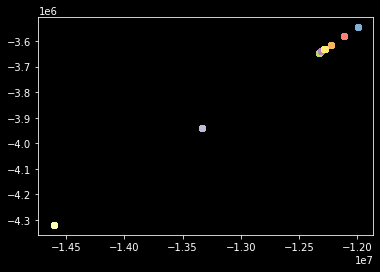

In [205]:
for i in range(1000):
    plt.scatter(d[0, i], d[1, i])
plt.show()

In [133]:
radius = 6371
A = np.zeros((6,6))
A[0:3, 0:3] = np.eye(3) * 2
A[0:3, 3:6] = np.eye(3) * -1
A[3:6, 0:3] = np.eye(3)

# prior = np.array([[lon, lat, alt]]).T
# zero = np.array([[0, 0, 0]]).T
# prior= np.concatenate((prior, zero), axis = 0 )
prior = np.array([[0, 0, 0, 0, 0, 0]])

C = np.eye(6)

gps_snapshot = data_interface.read()["gps_data"]
Q = np.zeros((6,6))
temp = gps_snapshot[4:].reshape((3,3))
Q[0:3, 0:3] = temp * 2
Q[3:6, 3: 6] = temp
prior[0, 0:3] = gps_snapshot[1:4]

gps_snapshot = data_interface.read()["gps_data"]
prior[0, 3:] = gps_snapshot[1:4]

kf = KalmanFilter(prior.T, A, C, Q)

In [134]:
timestamp = 0
mean_arr = []
cov_arr = []
pre_measure = np.zeros((3,1))

for t in range(1000):
    gps_snapshot = data_interface.read()["gps_data"]

    R = np.zeros((6,6))
    temp = gps_snapshot[4:].reshape((3,3))
    R[0:3, 0:3] = temp
    R[3:6, 3:6] = temp

    kf.predict(R)
    kf.update( np.concatenate((gps_snapshot[1:4].reshape((3,1)), pre_measure), axis = 0))
    pre_measure = gps_snapshot[1:4].reshape((3,1))
    m, c = kf.curr_state()
    mean_arr.append(m)
    cov_arr.append(c)
mean_arr = np.array(mean_arr)
cov_arr = np.array(cov_arr)

[[-1.69597029]
 [-5.83873569]
 [-1.86174976]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
[[ 35.30402971]
 [120.16126431]
 [ 34.13825024]
 [ 37.        ]
 [126.        ]
 [ 36.        ]] 
-----------------------
[[1.06238038]
 [3.3501606 ]
 [1.46219223]
 [0.        ]
 [0.        ]
 [0.        ]]
[[ 34.6704398 ]
 [117.67268921]
 [ 33.73869271]
 [ 35.30402971]
 [120.16126431]
 [ 34.13825024]] 
-----------------------
[[1.6786667 ]
 [5.54514469]
 [1.98497071]
 [0.        ]
 [0.        ]
 [0.        ]]
[[ 35.71551659]
 [120.7292588 ]
 [ 35.3241059 ]
 [ 34.6704398 ]
 [117.67268921]
 [ 33.73869271]] 
-----------------------
[[0.81638527]
 [2.93425359]
 [0.65454241]
 [0.        ]
 [0.        ]
 [0.        ]]
[[ 37.57697864]
 [126.72008198]
 [ 37.5640615 ]
 [ 35.71551659]
 [120.7292588 ]
 [ 35.3241059 ]] 
-----------------------
[[-0.5507715 ]
 [-1.54340617]
 [-0.94938133]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
[[ 38.8876692 ]
 [131.16749899]
 [ 38.85463576]
 [ 37.57697864]
 [126.72008

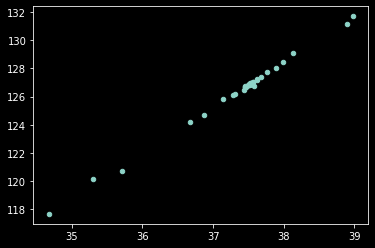

In [135]:
fig = plt.figure()
axes = fig.add_subplot()
axes.scatter(mean_arr[:, 0, :], mean_arr[:, 1, :], s=20)

In [ ]:
plotting_data = np.zeros((1000, 6))

for i in range(1000):
    plotting_data[i] = mean_arr[i].flatten()

In [ ]:
plotting_data

In [ ]:
plotting_data[:, 3].shape, plotting_data[:, 4].shape

In [ ]:
fig = plt.figure(figsize=(15, 15))
axis1 = plt.axes(projection="3d")
axis2 = plt.axes()

axis2.scatter(plotting_data[:, 0], plotting_data[:, 1])

In [ ]:
mean_arr.shape

In [ ]:
(C.T @ mean_arr).shape

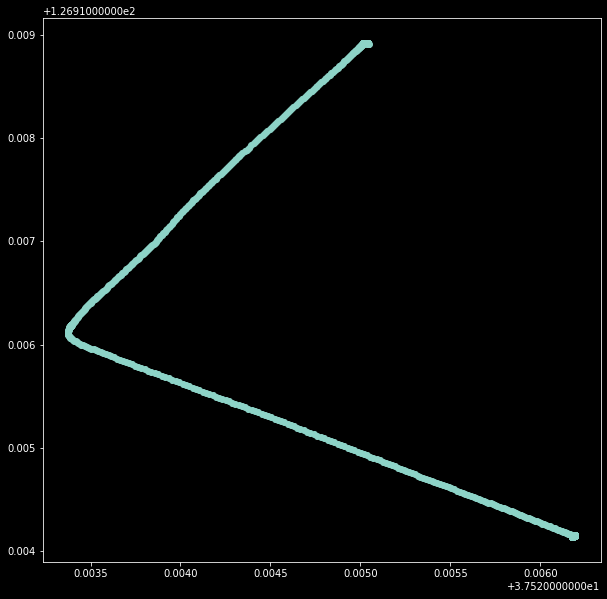

In [170]:
# plotting ground truth
gps_truth_data = np.genfromtxt("/home/jay/Documents/urban16/sensor_data/gps.csv", delimiter=",")
first_1000 = gps_truth_data[:1000, :]

fig = plt.figure(figsize=(10, 10))
axes = plt.axes()
axes.scatter(first_1000[:, 1], first_1000[:, 2])